In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_context("poster")
plt.rcParams['pdf.fonttype'] = 42

from PPTPseq_utils import qvalue, update_tf_name, read_COG_anno_ECO

## Determine significant promoter responses <a name="Z test"></a>

In [2]:
def Ztest_DEG(exp,nc):
    # exp: experimental group, nc: negative control group
    num_sgRNA = exp['sgRNA'].nunique()
    var_nc = (nc['std']**2/nc['n_rep'] + 1/2 * nc['std']**4/(nc['n_rep']-1)).repeat(num_sgRNA)
    var_nc = var_nc.reset_index(drop=True)
    var_exp = exp['std']**2/exp['n_rep'] + 1/2 * exp['std']**4/(exp['n_rep']-1)
    # calculate fold change
    FC = exp['mean'] - nc['mean'].repeat(num_sgRNA).reset_index(drop=True)
    FC_over_median = exp['mean'] - exp.groupby(['operon'])['mean'].median().repeat(num_sgRNA).reset_index(drop=True)
    # calculate Z score based on Zhou et al., 1997 Biometrics 53, 1129
    Z = FC/(np.sqrt(var_exp + var_nc))
    # calculate p value from Z score
    pvals = scipy.stats.norm.sf(abs(Z))*2
    # adjust the pvalue for multiple hypothesis test using q value method
    qvals = qvalue(pvals)
    # convert natural log fold change to log2 fold change
    exp['FC'] = FC/np.log(2)
    exp['FCOM'] = FC_over_median/np.log(2)
    # convert very small p values to 1e-10
    exp['-logP'] = -np.log10(qvals+1e-10)
    # divide the variants into three classes
    # 1: up regulated, -1: down regulated, 0: not significant
    exp['class'] = 0
    exp.loc[(exp['FC']>np.log2(1.7)) & (exp['FCOM']>np.log2(1.7)) & (exp['-logP']>2),'class'] = 1
    exp.loc[(exp['FC']<-np.log2(1.7)) & (exp['FCOM']<-np.log2(1.7)) & (exp['-logP']>2),'class'] = -1
    return exp

In [3]:
# load data
# read sort-seq data
log_GFP = pd.read_csv('../Processed_data/normalized_stat_exp_Glu.csv')
log_GFP_nc = pd.read_csv('../Processed_data/normalized_stat_nc_Glu.csv')

# differential expression analysis
DE_analysis_full_df = Ztest_DEG(log_GFP,log_GFP_nc)
DE_analysis_full_df.rename(columns={'sgRNA': 'tf_gene'}, inplace=True)
DE_analysis_full_df = update_tf_name(DE_analysis_full_df)

# calculate global effect
median_FC_operon = DE_analysis_full_df.groupby('operon')['FC'].median()
median_FC_tf = DE_analysis_full_df.groupby('tf_gene')['FC'].median()
DE_analysis_full_df = DE_analysis_full_df[DE_analysis_full_df['operon'].isin(median_FC_operon[median_FC_operon.notna()].index)].reset_index(drop = True)
DE_analysis_full_df['FC_global'] = pd.concat([median_FC_tf]*DE_analysis_full_df['operon'].nunique()).reset_index()['FC']
DE_analysis_full_df['FC_specific'] = DE_analysis_full_df['FC'] - DE_analysis_full_df['FC_global']

# remove sgRNAs that directly target TF promoters
self_targeting_sgRNA = pd.read_csv('../Processed_data/promoter-targeting_sgRNAs.txt', sep = '\t')
self_targeting_sgRNA.set_index(['operon','tf_gene'], inplace = True)
DE_analysis_full_df.set_index(['operon','tf_gene'], inplace = True)
DE_analysis_full_df_exclude = DE_analysis_full_df[~DE_analysis_full_df.index.isin(self_targeting_sgRNA.index)].reset_index()

The estimated proportion of truly null features is 0.463


,operon,tf_gene,mean,std,std_linear,n_rep,FC,FCOM,-logP,class,FC_global,FC_specific
8560,argG,argR,8.712991,0.192264,1129.837038,3,1.446096,1.386916,9.999999,1,0.139149,1.306947
38795,fadE,fadR,8.911010,0.233248,1729.871203,3,2.234414,2.176231,10.000000,1,0.036364,2.198050
65944,ilvIH,lrp,7.722539,0.278665,633.498823,2,-1.375453,-1.327609,4.329292,-1,0.537611,-1.913064
73944,lacZYA,lacI,9.589957,0.042958,633.751104,3,3.635757,3.568278,10.000000,1,0.376719,3.259038
81050,marRAB,marR,8.865373,0.164754,1224.178653,3,0.926056,0.880003,6.523319,1,0.088843,0.837213
83239,metE,metR,8.130601,0.204025,660.180024,3,-2.665028,-2.569823,10.000000,-1,-0.043872,-2.621157


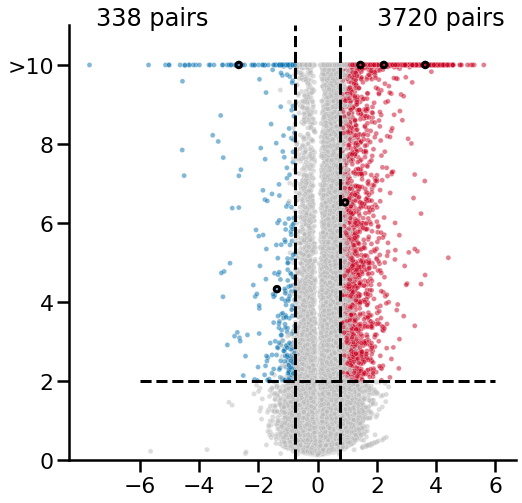

In [4]:
# Fig. 2a
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
x_limits = [-6,6]
y_limits = [0,11]
y_cutoff = 2
x_cutoff = np.log2(1.7)
consistence_cutoff = 0.7
dataset = DE_analysis_full_df_exclude[(DE_analysis_full_df_exclude['std']<consistence_cutoff)]
kws = {"s": 30, "facecolor": "none", "linewidth": 3}
sns.scatterplot(data = dataset, 
                x = 'FC', 
                y = '-logP', 
                hue='class', 
                s = 25, alpha = 0.5, palette=['#0571B0','#BABABA','#CA0020'], ax=ax)
sns.scatterplot(data = DE_analysis_full_df_exclude.iloc[[8560,38795,65944,73944,81050,83239]], x = 'FC', y = '-logP', edgecolor= 'k', **kws, ax=ax)
ax.plot(x_limits,[y_cutoff,y_cutoff],'k--')
ax.plot([x_cutoff,x_cutoff],y_limits,'k--')
ax.plot([-x_cutoff,-x_cutoff],y_limits,'k--')
ax.legend().remove()
sns.despine(bottom = False, left = False)
ax.annotate("{} pairs".format(dataset[dataset['class']==1].shape[0]), (2, 11))
ax.annotate("{} pairs".format(dataset[dataset['class']==-1].shape[0]), (-7.5, 11))
ax.set(
#     xlim=x_limits, 
       ylim=y_limits,
       yticks = [0,2,4,6,8,10],
       yticklabels = [0,2,4,6,8,'>10'],
       xticks = [-6,-4,-2,0,2,4,6],
       xlabel = "", 
       ylabel = "",
#        xlabel = "$log_{2}$(fold change)", 
#        ylabel = "$-log_{10}(q value)$",
      );
DE_analysis_full_df_exclude.iloc[[8560,38795,65944,73944,81050,83239]]

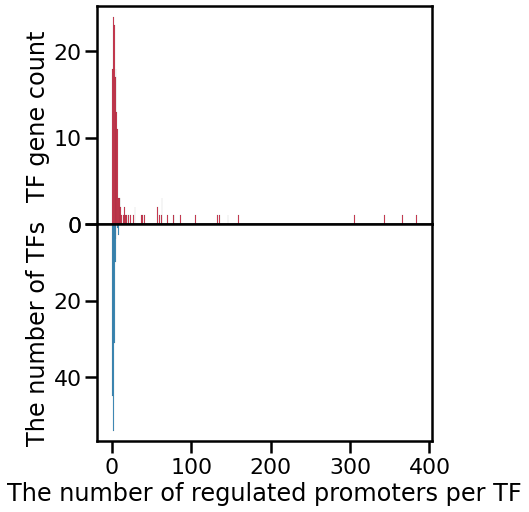

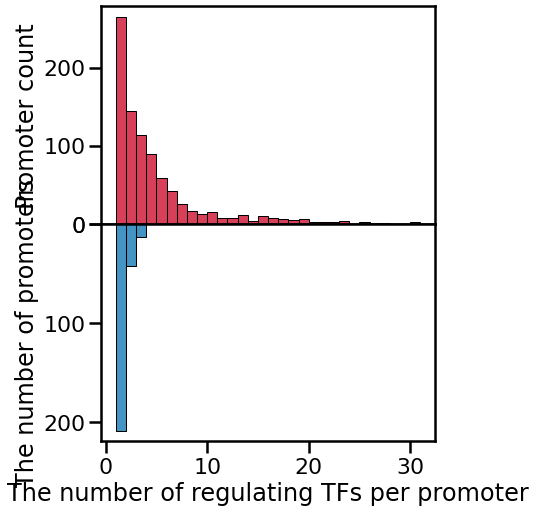

In [5]:
# Fig. 2b and c
fig, axes = plt.subplots(figsize=(6,8), nrows=2, sharex=True)
classes = [1,-1]
colors = ['#CA0020','#0571B0']
for i in range(2):
    sns.histplot(dataset[dataset['class']==classes[i]]['tf_gene'].value_counts(), 
                 color=colors[i], 
                #  bins=25, 
                 binwidth=1, 
                #  log_scale=True, 
                 ax = axes[i])
axes[0].set(ylabel = "TF gene count")
axes[1].set(xlabel = "The number of regulated promoters per TF", ylabel = "The number of TFs");
axes[1].invert_yaxis()
plt.subplots_adjust(hspace=0)
fig.savefig('../Figures/DEG/target_count_hist.pdf')
# Fig. 2c
fig, axes = plt.subplots(figsize=(6,8), nrows=2, sharex=True)
for i in range(2):
    sns.histplot(dataset[dataset['class']==classes[i]]['operon'].value_counts(), 
                 color=colors[i], 
                #  bins=25, 
                 binwidth=1, 
                #  log_scale=True, 
                 ax = axes[i])
axes[0].set(ylabel = "Promoter count")
axes[1].set(xlabel = "The number of regulating TFs per promoter", ylabel = "The number of promoters");
axes[1].invert_yaxis()
plt.subplots_adjust(hspace=0)
fig.savefig('../Figures/DEG/TF_count_hist.pdf')

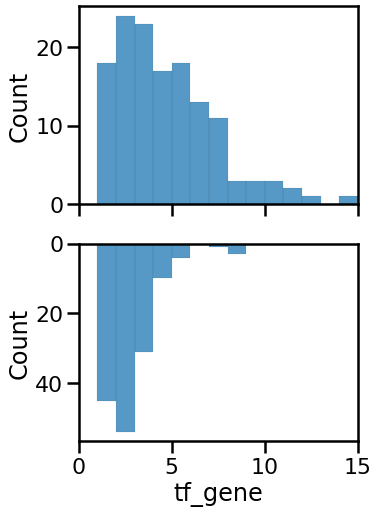

In [6]:
# the inset histogram
fig, axes = plt.subplots(figsize=(5,8), nrows=2, sharex=True)
sns.histplot(dataset[dataset['class']==1]['tf_gene'].value_counts(),binwidth=1, ax = axes[0])
sns.histplot(dataset[dataset['class']==-1]['tf_gene'].value_counts(),binwidth=1, ax = axes[1])
axes[0].set(xlim = [0,15])
axes[1].invert_yaxis()
fig.savefig('../Figures/DEG/target_count_hist_inset.pdf')

# Functional enrichment

COG functional annotation is used

In [11]:
# import COG annotation
# dataset = dataset.reset_index()
ECO_COG,COG_func = read_COG_anno_ECO()
COG2name = pd.Series(COG_func.name.values,index=COG_func.COG_cat).to_dict()
# define variable promoters and constant promoters
DE_only_df = dataset[(dataset['class']!=0)
                                # only consider specific effects when determining variable promoters
                                & (abs(dataset['FC_specific'])>np.log2(1.7)) ].reset_index(drop = True)
# calculate the number of variable promoters and constant promoters in each COG class
COG_anno_df = ECO_COG[ECO_COG['operon'].isin(dataset['operon'].unique())].reset_index(drop = True)
COG_anno_df_responsive = ECO_COG[ECO_COG['operon'].isin(DE_only_df['operon'].unique())].reset_index(drop = True)
promoter_COG_cat_count_df = pd.concat([COG_anno_df['COG_cat'].value_counts().rename('total'),
                                       COG_anno_df_responsive['COG_cat'].value_counts().rename('variable')],
                                      axis = 1)
promoter_COG_cat_count_df['constant'] = promoter_COG_cat_count_df['total'] - promoter_COG_cat_count_df['variable']
promoter_COG_cat_count_df['COG_name'] = promoter_COG_cat_count_df.index.map(COG2name)

In [12]:
# enrichment analysis using one-sided Fisher's exact test
M = promoter_COG_cat_count_df['total'].sum() # M: total number of annotated COG functions
n = promoter_COG_cat_count_df['total'] # n: total number of COG functions annotated as the "COG_cat"
N_v = promoter_COG_cat_count_df['variable'].sum() # N: total number of annotated COG functions in the gene set
x_v = promoter_COG_cat_count_df['variable'] # x: total number of COG functions annotated as the "COG_cat" in the gene set
N_c = promoter_COG_cat_count_df['constant'].sum() # N: total number of annotated COG functions in the gene set
x_c = promoter_COG_cat_count_df['constant'] # x: total number of COG functions annotated as the "COG_cat" in the gene set
promoter_COG_cat_count_df['v_ratio'] = promoter_COG_cat_count_df['variable']/promoter_COG_cat_count_df['total']
promoter_COG_cat_count_df['c_ratio'] = promoter_COG_cat_count_df['constant']/promoter_COG_cat_count_df['total']
c_ratio = 1 - DE_only_df['operon'].nunique()/dataset['operon'].nunique()
from scipy.stats import hypergeom
promoter_COG_cat_count_df['v_pvalue'] = hypergeom.sf(x_v, M, n, N_v) + hypergeom.pmf(x_v, M, n, N_v)
promoter_COG_cat_count_df['c_pvalue'] = hypergeom.sf(x_c, M, n, N_c) + hypergeom.pmf(x_c, M, n, N_c)
promoter_COG_cat_count_df = promoter_COG_cat_count_df.sort_values(by='c_ratio')
promoter_COG_cat_count_df

,total,variable,constant,COG_name,v_ratio,c_ratio,v_pvalue,c_pvalue
W,11,10,1,Extracellular structures,0.909091,0.090909,0.111798,0.980596
U,22,19,3,"Intracellular trafficking, secretion, and vesi...",0.863636,0.136364,0.066414,0.980078
N,26,22,4,Cell motility,0.846154,0.153846,0.071306,0.975072
V,48,39,9,Defense mechanisms,0.812500,0.187500,0.053925,0.974949
G,127,102,25,Carbohydrate transport and metabolism,0.803150,0.196850,0.004354,0.997756
D,18,14,4,"Cell cycle control, cell division, chromosome ...",0.777778,0.222222,0.330538,0.837528
K,183,134,49,Transcription,0.732240,0.267760,0.175959,0.865439
L,81,59,22,"Replication, recombination and repair",0.728395,0.271605,0.329653,0.756073
X,29,21,8,"Mobilome: prophages, transposons",0.724138,0.275862,0.476716,0.681615
F,54,39,15,Nucleotide transport and metabolism,0.722222,0.277778,0.421676,0.692610


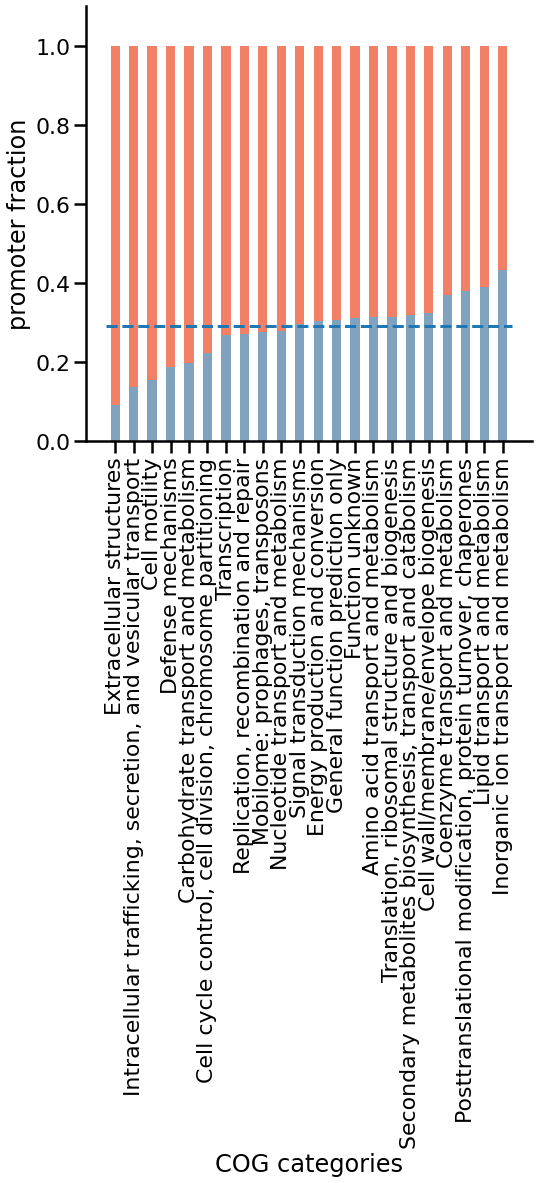

In [13]:
# Fig. 2d
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.bar(promoter_COG_cat_count_df.COG_name, promoter_COG_cat_count_df['c_ratio'], 
       color = '#7FA2BF', width=0.5, label = 'Constant promoters')
ax.bar(promoter_COG_cat_count_df.COG_name, promoter_COG_cat_count_df['v_ratio'], 
       color = '#F18066', width=0.5, bottom = promoter_COG_cat_count_df['c_ratio'], label = 'Variable promoters')
ax.plot([-0.5,21.5], [c_ratio,c_ratio], '--')
plt.xticks(rotation=90)
ax.set(ylabel = 'promoter fraction', xlabel = 'COG categories', ylim = [0,1.1]);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)